In [5]:
# Import all the necessary modules
%load_ext autoreload
%autoreload 2
from dagrad import dagrad # dagrad is the main class for learning the structure of a DAG
from dagrad import generate_linear_data, generate_nonlinear_data, count_accuracy, is_dag
import torch
import numpy as np
import matplotlib.pyplot as plt 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Linear SEM - EV method

In [45]:
def golem_ev(n, d, s0, graph_type, noise_type, error_var, seed=None):
    X, W_true, B_true = generate_linear_data(n,d,s0,graph_type,noise_type,error_var,seed)
    X = torch.from_numpy(X).float()
    model = 'linear' # Define the model
    W_golem = dagrad(
        X,
        model = model,
        method = 'dagma',
        compute_lib='torch',
        loss_fn='user_loss',
        reg='user_reg',
        h_fn='user_h',
        general_options={'user_params': {
            'equal_variances': True,
        }}
    ) # Learn the structure of the DAG using Golem
    print(f"Linear Model")
    print(f"data size: {n}, graph type: {graph_type}, nodes: {d}, edges: {s0}, sem type: {noise_type}")

    acc_golem = count_accuracy(B_true, W_golem != 0) # Measure the accuracy of the learned structure using Golem
    print('Accuracy of Golem:', acc_golem)

    return acc_golem

In [46]:
golem_ev(1000, 100, 50, 'ER', 'gauss', 'eq', seed=2)

Linear Model
data size: 1000, graph type: ER, nodes: 100, edges: 50, sem type: gauss
Accuracy of Golem: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 50}


{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 50}

In [47]:
# ER1 graph with 100 nodes, as in https://arxiv.org/pdf/2006.10201 5.1
n, d, s0, graph_type, noise_type = 1000, 100, 50, 'ER', 'gauss' # Define the parameters of the data
X, W_true, B_true = generate_linear_data(n,d,s0,graph_type,noise_type, error_var='eq',seed  =2) # Generate the data
X = torch.from_numpy(X).float()
model = 'linear' # Define the model
W_dagma = dagrad(
    X,
    model = model,
    method = 'dagma',
    compute_lib='torch',
) # Learn the structure of the DAG using Dagma
print(f"Linear Model")
print(f"data size: {n}, graph type: {graph_type}, sem type: {noise_type}")

acc_dagma = count_accuracy(B_true, W_dagma != 0) # Measure the accuracy of the learned structure using Dagma
print('Accuracy of Dagma:', acc_dagma)


Linear Model
data size: 1000, graph type: ER, sem type: gauss
Accuracy of Dagma: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 50}


In [48]:
golem_ev(1000, 100, 200, 'ER', 'gauss', 'eq', seed=2)

Linear Model
data size: 1000, graph type: ER, nodes: 100, edges: 200, sem type: gauss
Accuracy of Golem: {'fdr': 0.009950248756218905, 'tpr': 0.995, 'fpr': 0.0004210526315789474, 'shd': 2, 'nnz': 201}


{'fdr': 0.009950248756218905,
 'tpr': 0.995,
 'fpr': 0.0004210526315789474,
 'shd': 2,
 'nnz': 201}

In [49]:
# ER4 graph with 100 nodes, as in https://arxiv.org/pdf/2006.10201 5.1
n, d, s0, graph_type, noise_type = 1000, 100, 200, 'ER', 'gauss' # Define the parameters of the data
X, W_true, B_true = generate_linear_data(n,d,s0,graph_type,noise_type,error_var='eq',seed  =2) # Generate the data
X = torch.from_numpy(X).float()
model = 'linear' # Define the model
W_dagma = dagrad(
    X,
    model = model,
    method = 'dagma',
    compute_lib='torch',
) # Learn the structure of the DAG using Dagma
print(f"Linear Model")
print(f"data size: {n}, graph type: {graph_type}, sem type: {noise_type}")

acc_dagma = count_accuracy(B_true, W_dagma != 0) # Measure the accuracy of the learned structure using Dagma
print('Accuracy of Dagma:', acc_dagma)


Linear Model
data size: 1000, graph type: ER, sem type: gauss
Accuracy of Dagma: {'fdr': 0.0, 'tpr': 0.985, 'fpr': 0.0, 'shd': 3, 'nnz': 197}


### Linear SEM with EV noise - Two-stage method

In [9]:
def threshold_till_dag(B):
    """Remove the edges with smallest absolute weight until a DAG is obtained.

    Args:
        B (numpy.ndarray): [d, d] weighted matrix.

    Returns:
        numpy.ndarray: [d, d] weighted matrix of DAG.
        float: Minimum threshold to obtain DAG.
    """
    if is_dag(B):
        return B, 0

    B = np.copy(B)
    # Get the indices with non-zero weight
    nonzero_indices = np.where(B != 0)
    # Each element in the list is a tuple (weight, j, i)
    weight_indices_ls = list(zip(B[nonzero_indices],
                                 nonzero_indices[0],
                                 nonzero_indices[1]))
    # Sort based on absolute weight
    sorted_weight_indices_ls = sorted(weight_indices_ls, key=lambda tup: abs(tup[0]))

    for weight, j, i in sorted_weight_indices_ls:
        if is_dag(B):
            # A DAG is found
            break

        # Remove edge with smallest absolute weight
        B[j, i] = 0
        dag_thres = abs(weight)

    return B, dag_thres


def postprocess(B, graph_thres=0.3):
    """Post-process estimated solution:
        (1) Thresholding.
        (2) Remove the edges with smallest absolute weight until a DAG
            is obtained.

    Args:
        B (numpy.ndarray): [d, d] weighted matrix.
        graph_thres (float): Threshold for weighted matrix. Default: 0.3.

    Returns:
        numpy.ndarray: [d, d] weighted matrix of DAG.
    """
    B = np.copy(B)
    B[np.abs(B) <= graph_thres] = 0    # Thresholding
    B, _ = threshold_till_dag(B)

    return B

In [10]:
def golem_nv(n, d, s0, graph_type, sem_type, error_var, seed=None, intermediate_accuracy=True):
    X, W_true, B_true = generate_linear_data(n,d,s0,graph_type,sem_type,error_var,seed)
    X = torch.from_numpy(X).float()
    model = 'linear' # Define the model
    W_ev = dagrad(
        X,
        model = model,
        method = 'dagma',
        compute_lib='torch',
        loss_fn='user_loss',
        reg='user_reg',
        h_fn='user_h',
        general_options={'user_params': {
            'equal_variances': True,
        }}
    ) # Learn the structure of the DAG using Golem
    print(f"Linear Model")
    print(f"data size: {n}, graph type: {graph_type}, nodes: {d}, edges: {s0}, sem type: {sem_type}")

    if intermediate_accuracy:
        acc_ev = count_accuracy(B_true, W_ev != 0) # Measure the accuracy of the learned structure using Golem
        print('Accuracy of Golem after EV stage:', acc_ev)

    W_nv = dagrad(
        X,
        model = model,
        method = 'dagma',
        compute_lib='torch',
        loss_fn='user_loss',
        reg='user_reg',
        h_fn='user_h',
        general_options={'user_params': {
            'equal_variances': False,
        },
        'initialization': W_ev}
    ) 

    W_processed = postprocess(W_nv)
    acc_nv = count_accuracy(B_true, W_processed != 0) # Measure the accuracy of the learned structure using Golem
    print('Accuracy of Golem after NV stage:', acc_nv)

    return acc_nv


In [51]:
golem_nv(1000, 100, 200, 'ER', 'gauss', 'eq', seed=2)

Linear Model
data size: 1000, graph type: ER, nodes: 100, edges: 200, sem type: gauss
Accuracy of Golem after EV stage: {'fdr': 0.009950248756218905, 'tpr': 0.995, 'fpr': 0.0004210526315789474, 'shd': 2, 'nnz': 201}
Accuracy of Golem after NV stage: {'fdr': 0.009950248756218905, 'tpr': 0.995, 'fpr': 0.0004210526315789474, 'shd': 2, 'nnz': 201}


{'fdr': 0.009950248756218905,
 'tpr': 0.995,
 'fpr': 0.0004210526315789474,
 'shd': 2,
 'nnz': 201}

In [52]:
golem_nv(1000, 100, 50, 'ER', 'exp', 'eq', seed=2)

Linear Model
data size: 1000, graph type: ER, nodes: 100, edges: 50, sem type: exp
Accuracy of Golem after EV stage: {'fdr': 0.09259259259259259, 'tpr': 0.98, 'fpr': 0.0010204081632653062, 'shd': 5, 'nnz': 54}
Accuracy of Golem after NV stage: {'fdr': 0.14035087719298245, 'tpr': 0.98, 'fpr': 0.0016326530612244899, 'shd': 8, 'nnz': 57}


{'fdr': 0.14035087719298245,
 'tpr': 0.98,
 'fpr': 0.0016326530612244899,
 'shd': 8,
 'nnz': 57}

In [54]:
golem_nv(1000, 100, 50, 'ER', 'gauss', 'eq', seed=2)

Linear Model
data size: 1000, graph type: ER, nodes: 100, edges: 50, sem type: gauss
Accuracy of Golem after EV stage: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 50}
Accuracy of Golem after NV stage: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 50}


{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 50}

In [57]:
golem_nv(1000, 100, 200, 'ER', 'gauss', 'eq', seed=2)

Linear Model
data size: 1000, graph type: ER, nodes: 100, edges: 200, sem type: gauss
Accuracy of Golem after EV stage: {'fdr': 0.009950248756218905, 'tpr': 0.995, 'fpr': 0.0004210526315789474, 'shd': 2, 'nnz': 201}
Accuracy of Golem after NV stage: {'fdr': 0.009950248756218905, 'tpr': 0.995, 'fpr': 0.0004210526315789474, 'shd': 2, 'nnz': 201}


{'fdr': 0.009950248756218905,
 'tpr': 0.995,
 'fpr': 0.0004210526315789474,
 'shd': 2,
 'nnz': 201}

### Linear SEM with NV noise - Two-stage method

In [ ]:
golem_nv(1000, 100, 50, 'ER', 'gumbel', 'random', seed=2, intermediate_accuracy=False)

In [66]:
golem_nv(1000, 20, 10, 'ER', 'gauss', 'random', seed=2, intermediate_accuracy=False)

Linear Model
data size: 1000, graph type: ER, nodes: 20, edges: 10, sem type: gauss
Accuracy of Golem after NV stage: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 10}


{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 10}

### Experiment

In [68]:
def run_experiment(trials, error_var):
    """
    Parameters:
        trials (int): Number of trials to run for each configuration.
    
    Returns:
        None (Generates and saves plots).
    """
    n = 1000
    num_nodes = [5, 10]#, 50, 100]
    s0_ratios = [0.5, 1, 2]
    noise_types = ["gauss", "exp", "gumbel"]
    methods = ["GOLEM-EV", "GOLEM-NV"]

    results = {method: {sem: {d: [] for d in num_nodes} for sem in noise_types} for method in methods}

    for d in num_nodes:
        for sem_type in noise_types:
            for s0_ratio in s0_ratios:
                s0 = int(s0_ratio * d)

                for _ in range(trials):
                    ev_result = golem_ev(n=n, d=d, s0=s0, graph_type="ER", error_var=error_var, noise_type=sem_type)
                    results["GOLEM-EV"][sem_type][d].append(ev_result["shd"] / s0)

                    nv_result = golem_nv(n=n, d=d, s0=s0, graph_type="ER", error_var=error_var, sem_type=sem_type)
                    results["GOLEM-NV"][sem_type][d].append(nv_result["shd"] / s0)

    num_rows = len(s0_ratios)
    num_cols = len(noise_types)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)

    for i, s0_ratio in enumerate(s0_ratios):
        for j, noise in enumerate(noise_types):
            ax = axes[i, j] if num_rows > 1 else axes[j]
            
            for method in methods:
                means = [
                    np.mean(results[method][noise][d])
                    for d in num_nodes
                ]
                ax.plot(num_nodes, means, marker="o", label=method)

            noise_names = {
                "gauss": "Gaussian",
                "exp": "Exponential",
                "gumbel": "Gumbel"
            }
            s0_ratio_to_ER = {
                0.5: '1',
                1: '2',
                2: '4'
            }

            ax.set_title(f"{noise_names[noise]} noise, ER{s0_ratio_to_ER[s0_ratio]}")
            ax.set_xlabel("d (Number of Nodes)")
            if j == 0:
                ax.set_ylabel("Normalized SHD")
            ax.grid(True)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=len(methods))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"normalized_shd_n={n}.png")

Linear Model
data size: 1000, graph type: ER, nodes: 5, edges: 2, sem type: gauss
Accuracy of Golem: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 2}
Linear Model
data size: 1000, graph type: ER, nodes: 5, edges: 2, sem type: gauss
Accuracy of Golem after EV stage: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 2}
Accuracy of Golem after NV stage: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 2}
Linear Model
data size: 1000, graph type: ER, nodes: 5, edges: 5, sem type: gauss
Accuracy of Golem: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}
Linear Model
data size: 1000, graph type: ER, nodes: 5, edges: 5, sem type: gauss
Accuracy of Golem after EV stage: {'fdr': 0.2, 'tpr': 0.8, 'fpr': 0.2, 'shd': 1, 'nnz': 5}
Accuracy of Golem after NV stage: {'fdr': 0.2, 'tpr': 0.8, 'fpr': 0.2, 'shd': 1, 'nnz': 5}
Linear Model
data size: 1000, graph type: ER, nodes: 5, edges: 10, sem type: gauss
Accuracy of Golem: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 

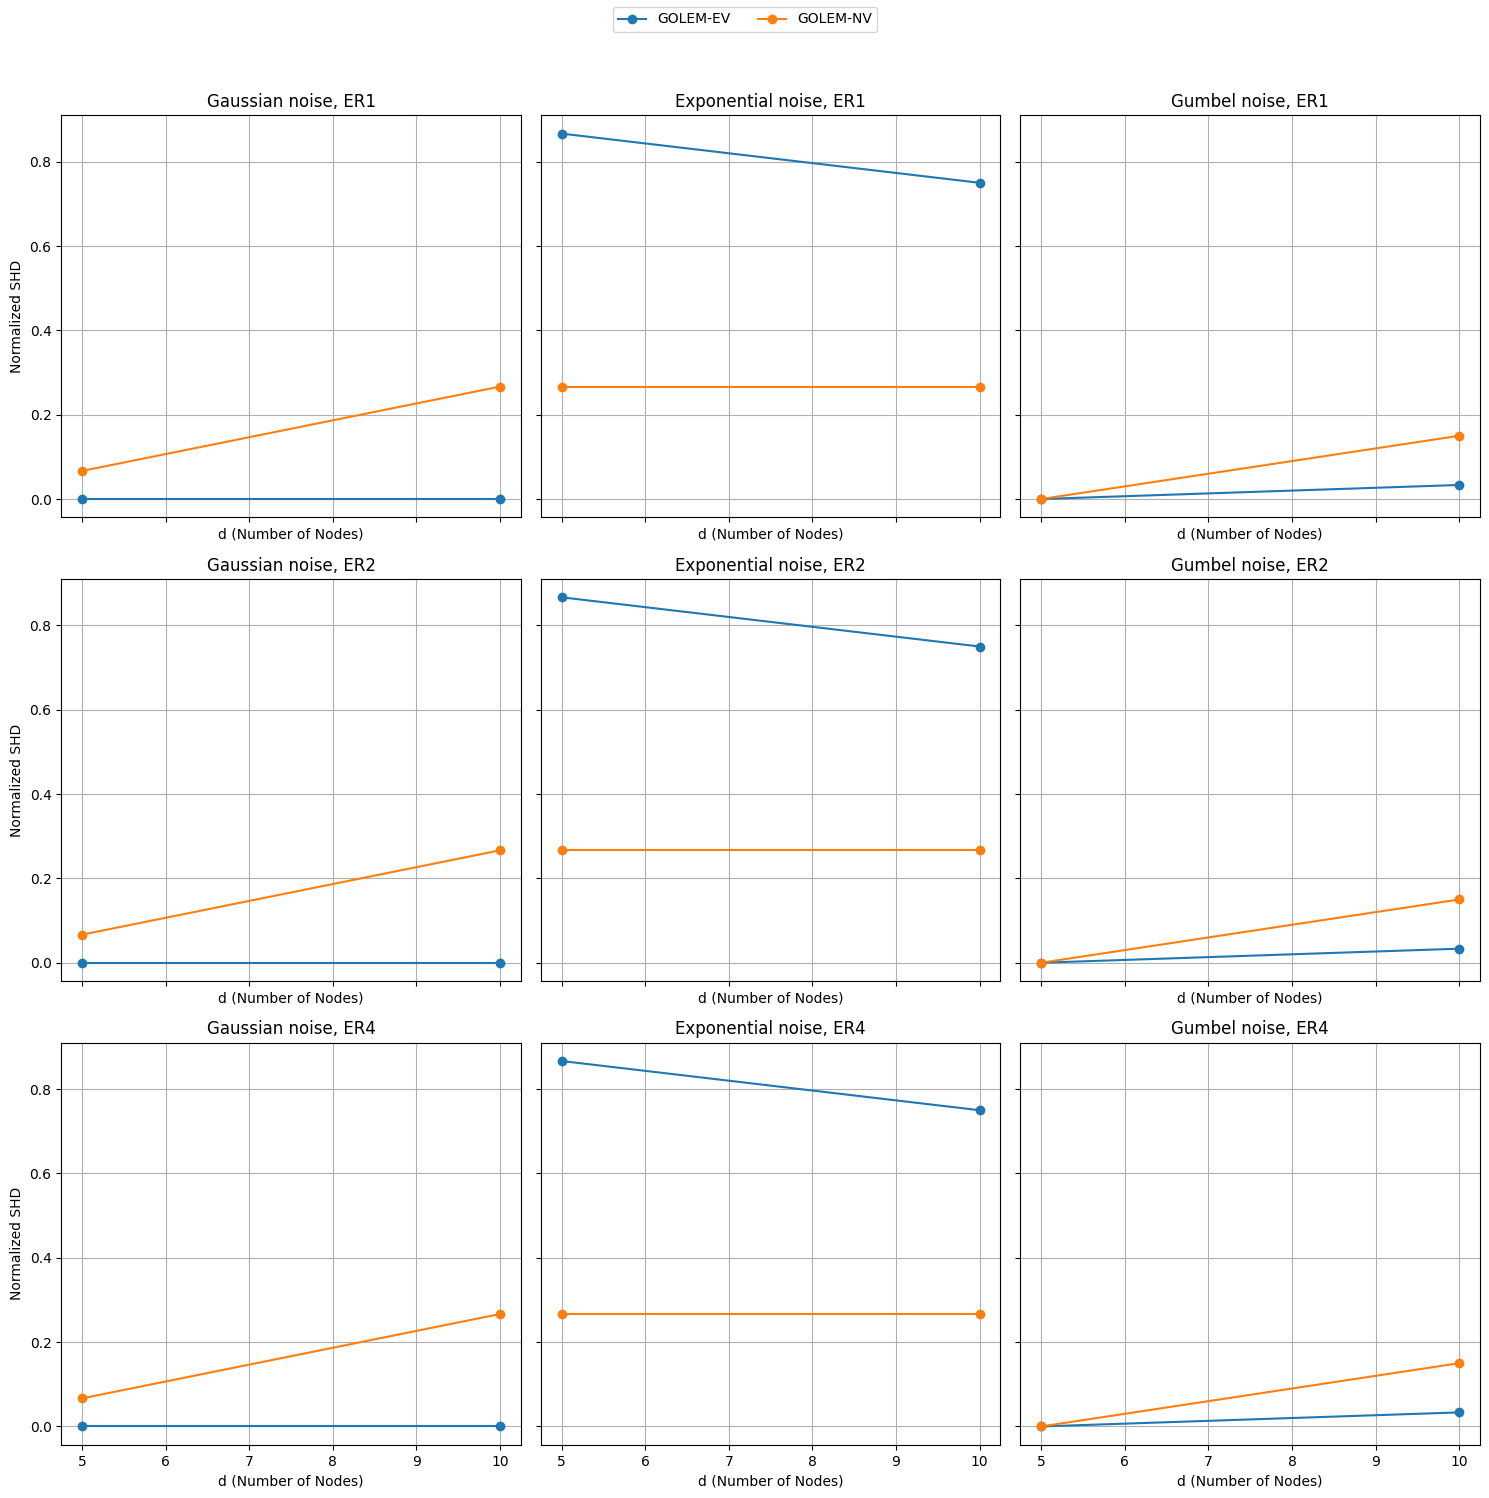

In [70]:
run_experiment(1, 'eq')

Linear Model
data size: 1000, graph type: ER, nodes: 5, edges: 2, sem type: gauss
Accuracy of Golem: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 2}
Linear Model
data size: 1000, graph type: ER, nodes: 5, edges: 2, sem type: gauss
Accuracy of Golem after EV stage: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 2}
Accuracy of Golem after NV stage: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 2}
Linear Model
data size: 1000, graph type: ER, nodes: 5, edges: 5, sem type: gauss
Accuracy of Golem: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}
Linear Model
data size: 1000, graph type: ER, nodes: 5, edges: 5, sem type: gauss
Accuracy of Golem after EV stage: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}
Accuracy of Golem after NV stage: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 5}
Linear Model
data size: 1000, graph type: ER, nodes: 5, edges: 10, sem type: gauss
Accuracy of Golem: {'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 

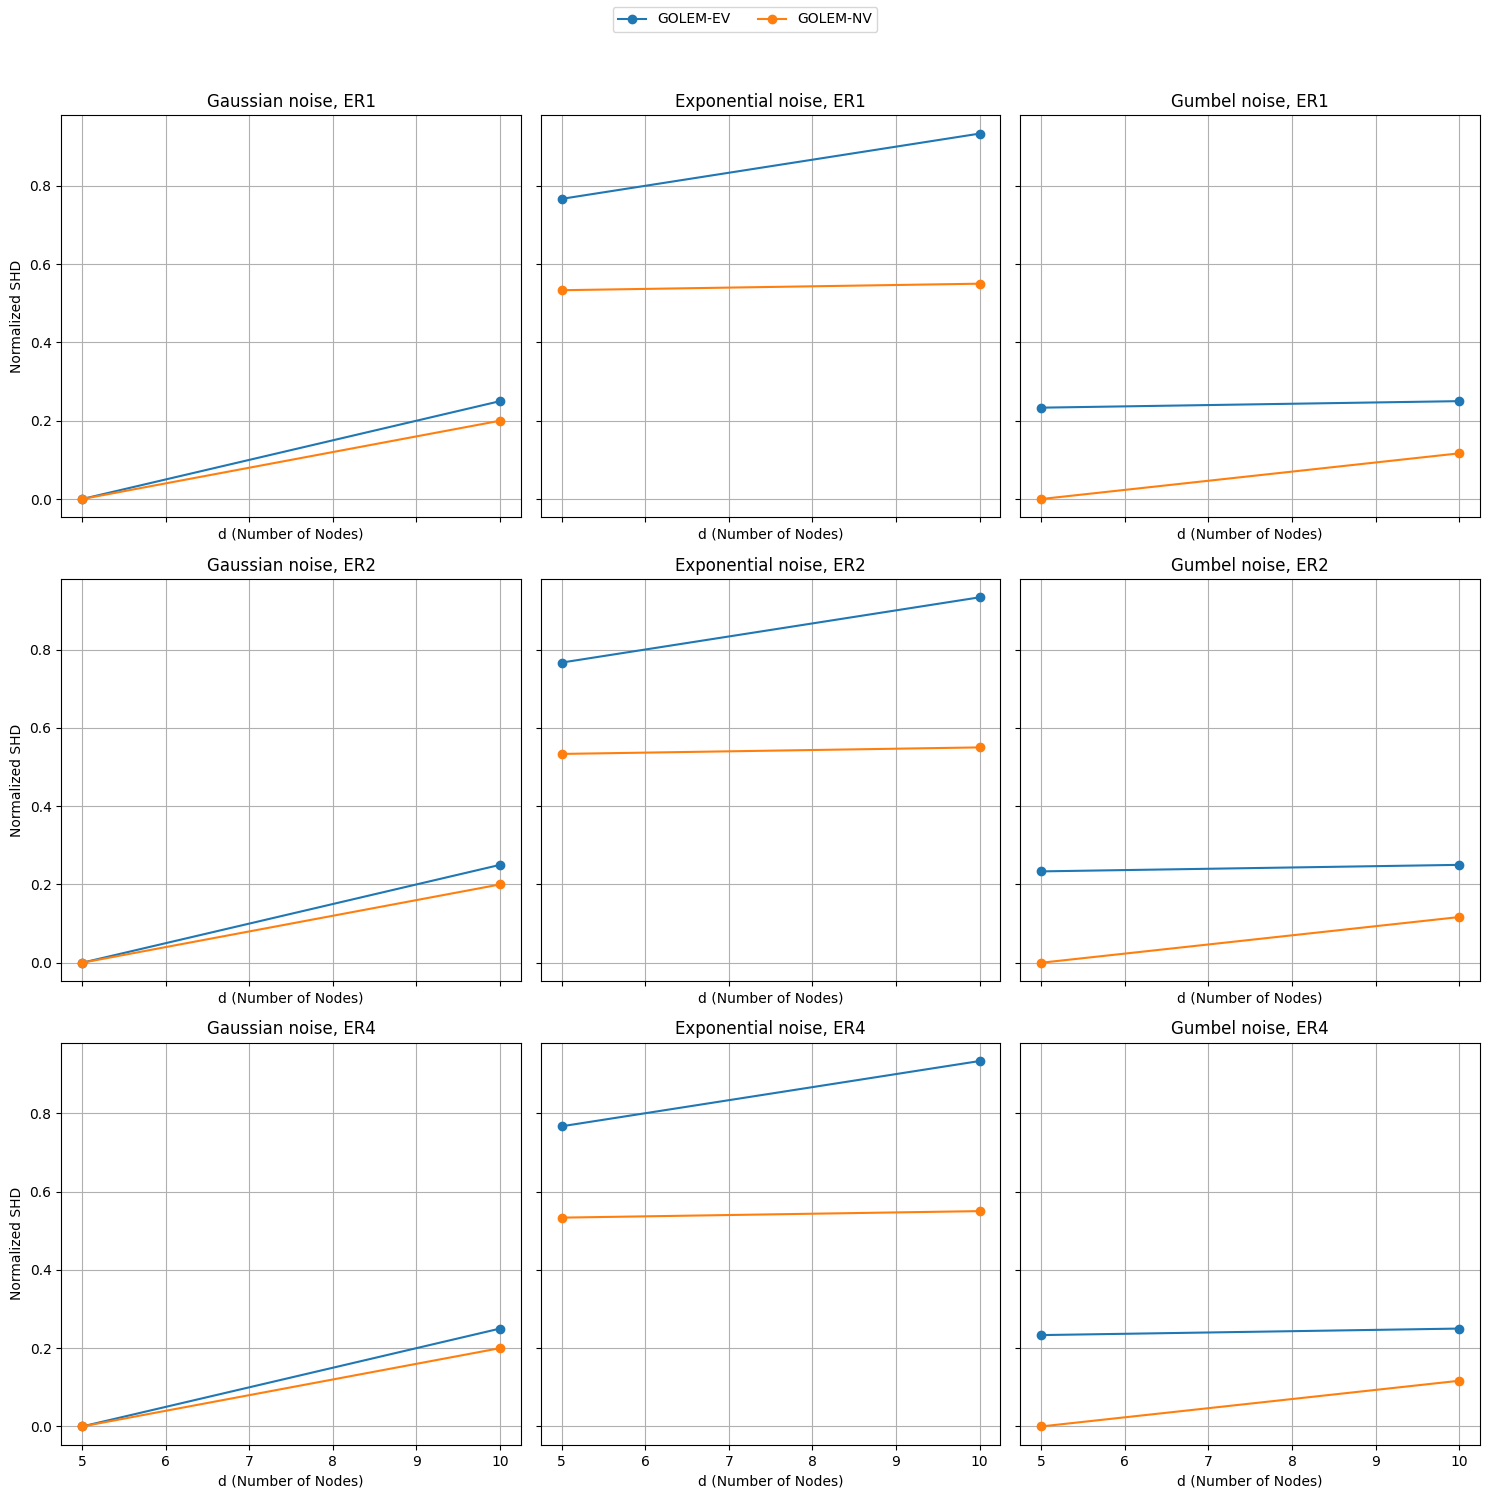

In [71]:
run_experiment(1, 'random')